## DBSCAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pickle

import sys
import os
sys.path.append('../..')
from src.utils.directories import get_parent_directory
from sklearn.cluster import DBSCAN
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
parent_dir = get_parent_directory()
all_pkl_path = (os.path.join(parent_dir, "data/processed/ml_ready/merged_all.pkl"))

with open(all_pkl_path, 'rb') as f:
    data = pickle.load(f)

# clustering preparation

In [5]:
max_points_per_latitude = 5

# Subsample the DataFrame
subsampled_df = data.groupby('latitude', group_keys=False).apply(lambda group: group.sample(n=min(max_points_per_latitude, len(group)), random_state=42))

# Reset the index of the subsampled DataFrame
subsampled_df.reset_index(drop=True, inplace=True)

In [8]:
data = subsampled_df

In [9]:
var_df = data[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]

# Keep the column names
column_names = var_df.columns

X = var_df

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add the column names back to the X_scaled array
X_scaled = pd.DataFrame(X_scaled, columns=column_names)

In [35]:
X = X_scaled

# Instantiate the DBSCAN model
epsilon = 0.2  # Maximum distance between two samples for one to be considered as in the neighborhood of the other
min_samples = 20  # The minimum number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

# Fit the DBSCAN model to your data
dbscan.fit(X)

# Get cluster labels for each data point
cluster_labels = dbscan.labels_

In [37]:
X_input = X[['S', 'T', 'log_eps', 'log_N2', 'dTdz', 'dSdz']]
# X_output = X[['Cluster']]

# Use the inverse_transform method to anti-scale X_scaled
transformed_df = pd.DataFrame(scaler.inverse_transform(X_input), columns=X_input.columns)

# Add cluster labels to the DataFrame
transformed_df['Cluster'] = dbscan.labels_

# Round the values in the DataFrames to a specific number of decimal places
decimals = 4  # Adjust as needed
data_rounded = data.round(decimals)
transformed_df_rounded = transformed_df.round(decimals)

# Merge based on multiple columns (A and B)
merged_df = transformed_df_rounded.merge(data_rounded, on=['S', 'T', 'log_eps', 'log_N2', 'dSdz', 'dTdz'], how='left')

cluster_crisis_groups = merged_df.groupby(['Cluster', 'cruise']).size().unstack(fill_value=0)
cluster_crisis_groups

cruise,1,2,3,4,5,6,7,8,9,10,...,ASCOS,ArcticMix,Haakon Mosby,IPY Barneo 2007,IPY Barneo 2008,Mosaic,NICE-2015,Nansen Legacy 2018,Nansen Legacy 2019,TEA_COSI
Cluster,,,,,,,,,,,,,,,,,,,,,
-1,65,96,4,4,115,8,35,48,12,188,...,22,1456,126,8,9,501,580,151,129,1237
0,290,340,46,216,85,36,11,17,102,276,...,992,0,117,447,851,4667,2345,240,86,2
1,1,0,0,0,0,0,2,0,8,25,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,11,30,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,1,2,0,2,116,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,170,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,20,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,1663,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,35,0,0,0,0,0,0,0,0


In [41]:
# Analyse cluster 0
cluster_0_data = merged_df[merged_df['Cluster'] == 0]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                  S             T       log_eps        log_N2          dTdz  \
count  11638.000000  11638.000000  11638.000000  11638.000000  11638.000000   
mean      34.349310      0.589536     -9.039525     -5.043621      0.008833   
std        0.798377      1.952502      0.634418      0.774773      0.014299   
min       29.245000     -1.889100    -10.903400     -7.968400     -0.025000   
25%       34.218625     -1.578975     -9.285375     -5.631000      0.000000   
50%       34.652250      0.969700     -9.050500     -4.990650      0.002000   
75%       34.851600      1.913750     -8.781600     -4.428625      0.015100   
max       35.339400      7.440400     -5.875400     -3.187400      0.083500   

               dSdz  Cluster         depth        profile      latitude  \
count  11638.000000  11638.0  11638.000000   11638.000000  11638.000000   
mean       0.004334      0.0   -544.862161    3519.245261     68.196245   
std        0.007000      0.0   1652.279930   22037.821333     4

In [44]:
# Analyse cluster 1
cluster_0_data = merged_df[merged_df['Cluster'] == -1]
cluster_0_statistics = cluster_0_data.describe()
print(cluster_0_statistics)

                 S           T      log_eps       log_N2         dTdz  \
count  5354.000000  5354.00000  5354.000000  5354.000000  5354.000000   
mean     24.746375     2.44510    -7.385180    -5.338955     0.004322   
std      15.257908     4.89010     1.789585     4.641912     0.124039   
min      -9.804300    -2.44090   -11.202600   -28.369100    -1.923500   
25%       0.000000    -0.88145    -8.875950    -8.961050    -0.008100   
50%      34.004950     0.89260    -7.799850    -4.490700     0.001700   
75%      34.819375     4.08305    -5.911850    -0.118200     0.026075   
max      37.313700    28.93690    -0.016800     0.033000     0.904900   

              dSdz  Cluster        depth        profile     latitude  \
count  5354.000000   5354.0  5350.000000    5350.000000  5350.000000   
mean      0.032654     -1.0  -407.334319    1459.550194    67.146419   
std       0.111463      0.0  1407.414561   12918.655132    26.396160   
min      -0.304100     -1.0 -5904.000000       0.00000

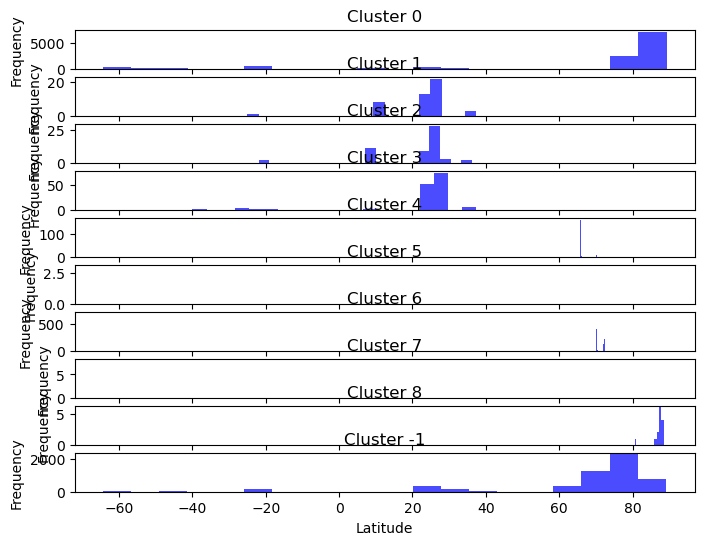

In [38]:
# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(merged_df['Cluster'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(merged_df['Cluster']), axes):
    # Filter data points for the current cluster
    cluster_data = merged_df[merged_df['Cluster'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

#plt.tight_layout()
plt.show()


## Plot clusters

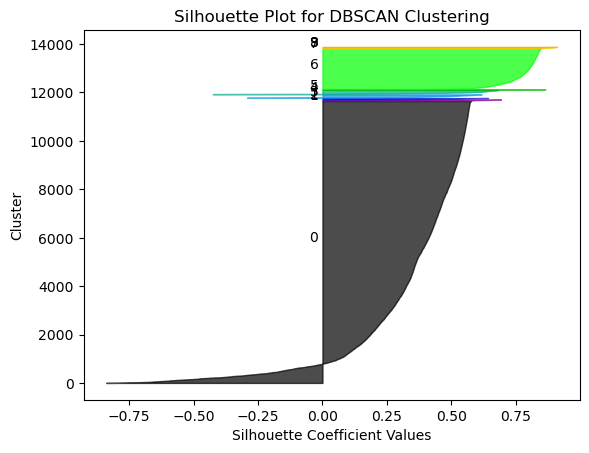

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

silhouette_avg = silhouette_score(X, cluster_labels)
sample_silhouette_values = silhouette_samples(X, cluster_labels)

# Create a silhouette plot
y_lower = 10
for i in range(len(set(cluster_labels))):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(set(cluster_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add 10 for the next plot

# Add a title and axis labels
plt.title("Silhouette Plot for DBSCAN Clustering")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


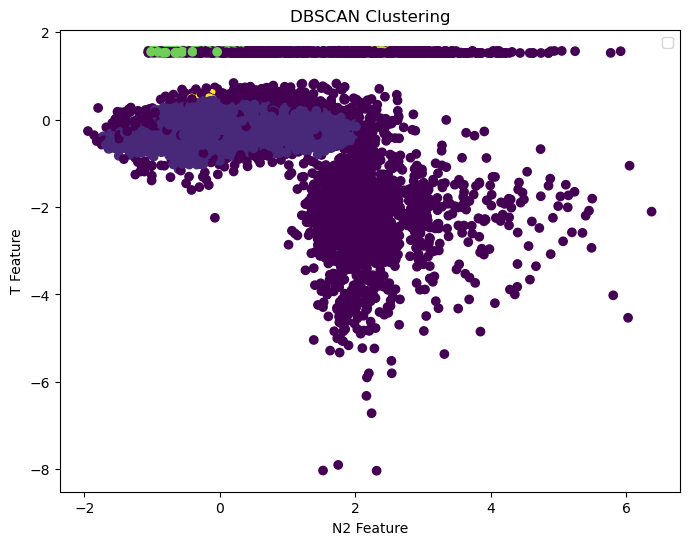

In [40]:
# Select the two features (N2 and T) for plotting
feature_N = X['log_eps']
feature_T = X['log_N2']

# Plot the data points with cluster assignments from DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(feature_N, feature_T, c=cluster_labels, cmap='viridis')
# If you have access to the cluster centers in DBSCAN, you can plot them as well.
# Otherwise, omit this line.
# plt.scatter(db.cluster_centers_[:, 0], db.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.title('DBSCAN Clustering')
plt.xlabel('N2 Feature')
plt.ylabel('T Feature')
plt.legend()
plt.show()


In [ ]:

# Create a figure and axis for the histograms
fig, axes = plt.subplots(len(set(df['cluster_labels'])), figsize=(8, 6), sharex=True)

for cluster_label, ax in zip(set(df['cluster_labels']), axes):
    # Filter data points for the current cluster
    cluster_data = df[df['cluster_labels'] == cluster_label]
    
    # Plot a histogram of the latitude values for the current cluster
    ax.hist(cluster_data['latitude'], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Cluster {cluster_label}')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()